##### Test by independent Gillespie simulation

In [1]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import scipy.stats as stats
import copy

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


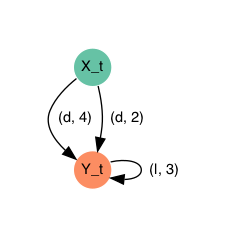

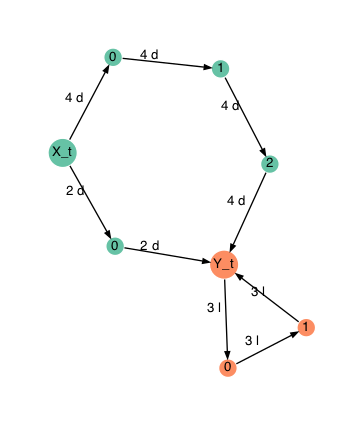

In [5]:
# old: test is based on the following specific network
# t = [
#     {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
#     {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

#     {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
#     {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

#     {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
#     ]

# new multigraph version
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

net = me.Network('net_test_2')
net.structure(t)

me.plots.net_main_plot(net)
me.plots.net_hidden_plot(net)

##### Gillespie simulations (independent / framework external)

In [3]:
def gill_indep_test_2(initial_state, time_values, d4, d2, l, num_iter):
    # initialisation
    res = np.zeros((num_iter, 8, time_values.shape[0]))
    
    for i in range(num_iter):
        time_current = time_values[0]
        time_max = time_values[-1]
        cell_state = np.zeros(8)
        cell_state = copy.deepcopy(initial_state)
        
#         print('iter: ', i)
#         print('time_current: ', time_current)
#         print('time_max: ', time_max)
#         print('cell_state: ', cell_state)
        
        while time_current <= time_max:
            # reaction propensities
            reac_props = np.array([
                # NOTE: division by 2 in the diff channels is only due to
                # current workaround for multigraphs (with P intermediate nodes)
                # WAS REMOVED HERE
                
                # differentiation d4 channel
                4.0 * d4 * cell_state[0], # d from Xcentric to X0
                4.0 * d4 * cell_state[1], # d from X0 to X1
                4.0 * d4 * cell_state[2], # d from X1 to X2
                4.0 * d4 * cell_state[3], # d from X2 to Ycentric
                
                # differentiation d2 channel
                2.0 * d2 * cell_state[0], # d from Xcentric to X0
                2.0 * d2 * cell_state[4], # d from X0 to X1
                
                # division
                3.0 * l * cell_state[5], # l from Ycentric to Y0
                3.0 * l * cell_state[6], # l from Y0 to Y1
                3.0 * l * cell_state[7], # l from Y1 to Ycentric
            ])
#             print('\n while start')
#             print('reac_props: ', reac_props)

            # draw exponential random time for next reaction
            total_prop = np.sum(reac_props)
            dt = np.random.exponential(1.0/total_prop)
            
#             print('total_prop: ', total_prop)
#             print('dt: ', dt)

            # save cell state results for relevant time points
            for ind in np.where((time_values >= time_current) 
                                & (time_values < time_current + dt))[0]:
                res[i, :, ind] = copy.deepcopy(cell_state).reshape((1,8))
            
#             print('res: ', res)
            
            # draw which reaction takes place
            reac_probs = reac_props/np.sum(reac_props)
            reac_rand = np.random.choice(reac_props.shape[0], p=reac_probs)
            
#             print('reac_probs: ', reac_probs)
#             print('reac_rand: ', reac_rand)

            # update cell state according to selected reaction
            # differentiation d4 channel
            if reac_rand==0:
                cell_state[0] += -1.0
                cell_state[1] += +1.0
            elif reac_rand==1:
                cell_state[1] += -1.0
                cell_state[2] += +1.0
            elif reac_rand==2:
                cell_state[2] += -1.0
                cell_state[3] += +1.0
            elif reac_rand==3:
                cell_state[3] += -1.0
                cell_state[5] += +1.0
                
            # differentiation d2 channel
            elif reac_rand==4:
                cell_state[0] += -1.0
                cell_state[4] += +1.0
            elif reac_rand==5:
                cell_state[4] += -1.0
                cell_state[5] += +1.0 

            # division
            elif reac_rand==6:
                cell_state[5] += -1.0
                cell_state[6] += +1.0
            elif reac_rand==7:
                cell_state[6] += -1.0
                cell_state[7] += +1.0
            elif reac_rand==8:
                cell_state[7] += -1.0
                cell_state[5] += +2.0
            else:
                print('error')

            # update current time by delta t
            time_current += dt
            
#             print('cell_state: ', cell_state)
#             print('time_current: ', time_current)
#             print('\n')
    
    # sum hidden states to get observable layer
    res_obs = np.zeros((num_iter, 2, time_values.shape[0]))
    res_obs[:, 0, :] = np.sum(res[:, (0,1,2,3,4), :], axis=1)
    res_obs[:, 1, :] = np.sum(res[:, (5,6,7), :], axis=1)
    return res_obs

In [8]:
# order of the variables of the hidden layer
# 0,1,2,3,4: X centric, X diff4 0, X diff4 1, X diff4 2, X diff2 0, 
# 5,6,7: Y centric, Y div 0, Y div 1
initial_values = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
d4 = 0.03
d2 = 0.04
l = 0.06
num_iter = 50000
print(time_values)

# save result as external simulation results
sim_res_ext = gill_indep_test_2(initial_values, time_values, d4, d2, l, num_iter)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]


In [9]:
print(sim_res_ext.shape)

(50000, 2, 28)


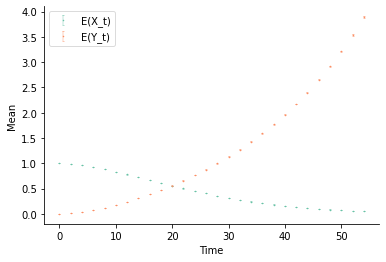

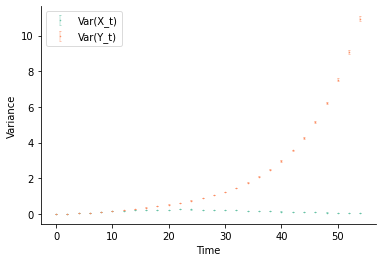

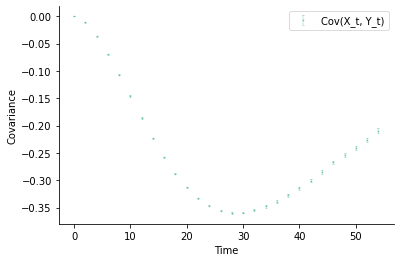

In [10]:
data_ext = me.Data('data_test_2_external')
data_ext.load(['X_t', 'Y_t'], time_values, sim_res_ext, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_ext)
me.plots.data_variance_plot(data_ext)
me.plots.data_covariance_plot(data_ext)

##### Gillespie simulations (framework)

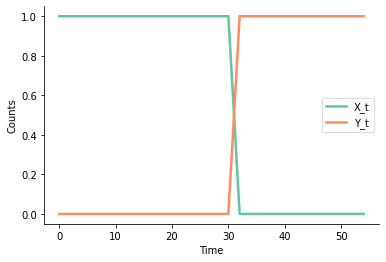

In [13]:
# compute Gillespie simulation with the framework
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd4': 0.03, 'd2': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_2')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('gillespie', variables, initial_values, theta_values, time_values)

me.plots.sim_counts_plot(sim)

In [14]:
# create a data object from simulations for the estimation
num_iter = 50000

res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sim_res_int = np.array(res_list)

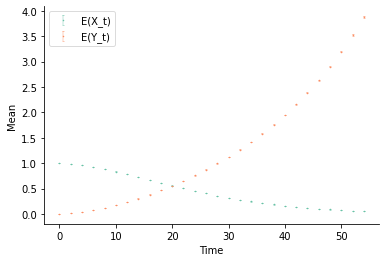

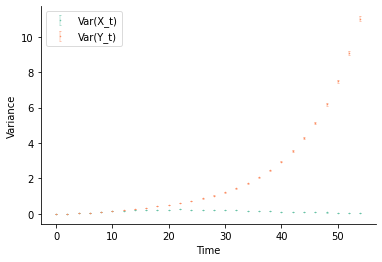

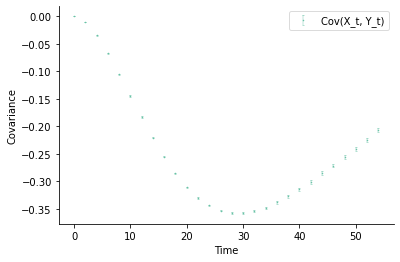

In [15]:
data_int = me.Data('data_test_2_internal')
data_int.load(['X_t', 'Y_t'], time_values, sim_res_int, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_int)
me.plots.data_variance_plot(data_int)
me.plots.data_covariance_plot(data_int)

##### Moment simulations (framework)

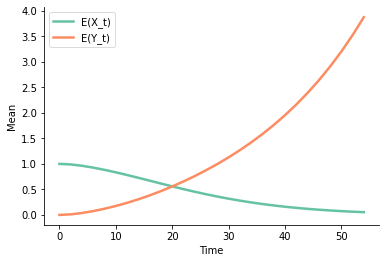

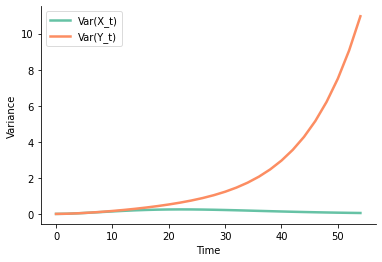

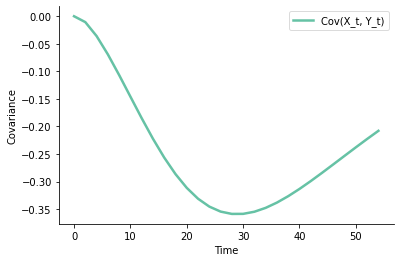

In [19]:
# multigraphs are not yet implemented, but maybe it just works:
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd4': 0.03, 'd2': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_2')
net.structure(t)

sim = me.Simulation(net)
sim_res_mom_mult = sim.simulate('moments', variables, initial_values, theta_values, time_values)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

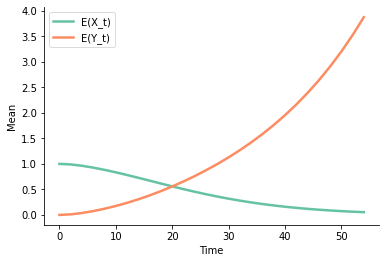

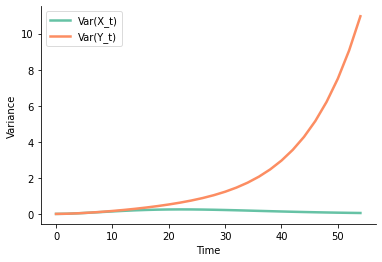

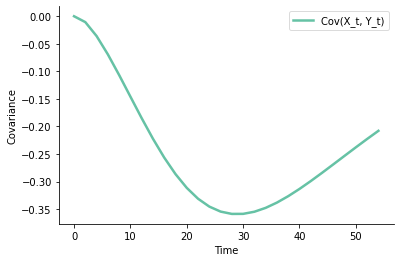

In [20]:
# current implementation way of two parallel channels
t = [
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0}
theta_values = {'l': 0.06, 'd4': 0.06, 'd2': 0.08}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )}

netp = me.Network('net_test_2')
netp.structure(t)

sim = me.Simulation(netp)
sim_res_mom = sim.simulate('moments', variables, initial_values, theta_values, time_values)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

In [21]:
print(np.allclose(sim_res_mom[0], sim_res_mom_mult[0]))
print(np.allclose(sim_res_mom[1], sim_res_mom_mult[1]))
print(np.allclose(sim_res_mom[2], sim_res_mom_mult[2]))

True
True
True


##### fit true model to see if evidence is the same

In [22]:
# test compare estimation old and new version
# NOTE: need to adapt theta_bounds to get same evidence
# first and third est should be the same
nets = [netp, net, net]
variables = [{'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )},
            {'X_t': ('X_t', ), 'Y_t': ('Y_t', )},
            {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]
initial_values = [{'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0},
                 {'X_t': 1, 'Y_t': 0},
                  {'X_t': 1, 'Y_t': 0}]
theta_bounds = [{'d4': (0.0, 0.15), 'd2': (0.0, 0.15), 'l': (0.0, 0.15)},
               {'d4': (0.0, 0.15), 'd2': (0.0, 0.15), 'l': (0.0, 0.15)},
               {'d4': (0.0, 0.15), 'd2': (0.0, 0.15/2), 'l': (0.0, 0.15/2)}]
        
est_res_int = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_int, parallel=False)

In [23]:
[est.bay_est_log_evidence for est in est_res_int]

[694.6356918318183, 692.9931553904444, 694.528159392624]

In [24]:
est_res_ext = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_ext, parallel=False)

In [25]:
[est.bay_est_log_evidence for est in est_res_ext]

[700.9257773433735, 699.7685226355138, 701.0726107887706]

##### Models for estimation

In [26]:
def make_net(steps_d4, steps_d2, steps_l):
    name = 'net_' + str(steps_d4) + '_' + str(steps_d2) + '_' + str(steps_l)

    t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': steps_d4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': steps_d2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': steps_l}
    ]
    
    net = me.Network(name)
    net.structure(t)

    return net

nets = [make_net(steps_d4, steps_d2, steps_l) for steps_d4 in [2, 4, 6]
                                                  for steps_d2 in [2, 4, 6]
                                                  for steps_l in range(1, 6)]
print(len(nets))

45


##### Estimation of internal simulated data

In [27]:
variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]*len(nets)
initial_values = [{'X_t': 1, 'Y_t': 0}]*len(nets)
theta_bounds = [{'d4': (0.0, 0.15/2), 'd2': (0.0, 0.15/2), 'l': (0.0, 0.15)}]*len(nets)
        
est_res_int = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_int, parallel=True)

In [28]:
net_names = [est.net.net_name for est in est_res_int]
model_probs = me.selection.compute_model_probabilities(est_res_int)
print(net_names.index('net_4_2_3')) # true model
print(net_names.index('net_2_4_3')) # symmetric true model

17
7


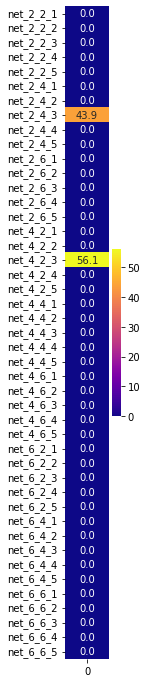

In [29]:
df = pd.DataFrame(model_probs * 100.0, index=net_names)
plt.figure(figsize=(1, 12)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.show()
# first run: 
# net_2_4_3 51.2%
# net_4_2_3 48.8%
# second run (new simulation data): 
# net_2_4_3 69.0%
# net_4_2_3 31.0%

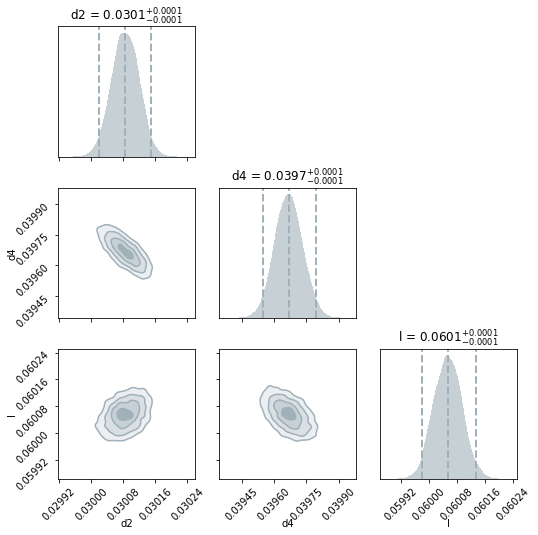

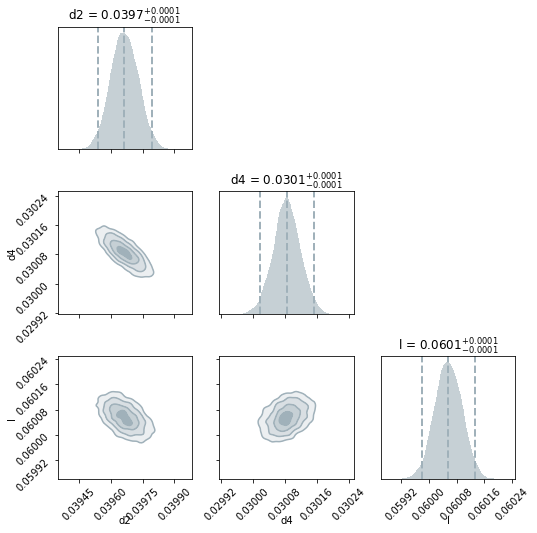

In [30]:
est = est_res_int[7]
me.plots.est_corner_kernel_plot(est)

est = est_res_int[17]
me.plots.est_corner_kernel_plot(est)
# first run estimated rates:
# net_4_2_3: d2=0.076, d4=0.063, l=0.060
# second run estimated rates (new simulation data):
# net_4_2_3: d2=0.080, d4=0.060, l=0.060

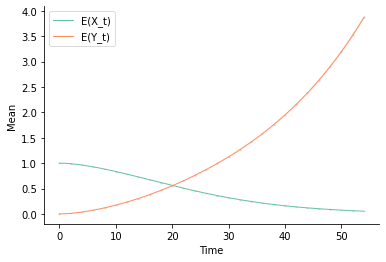

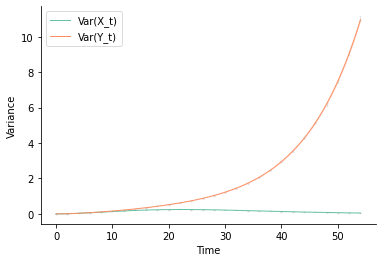

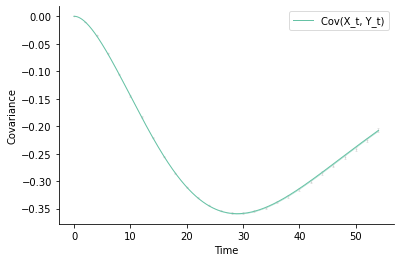

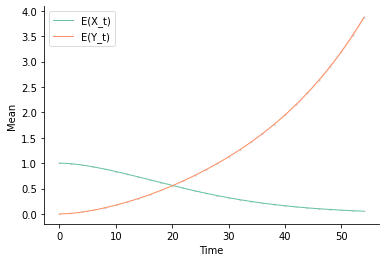

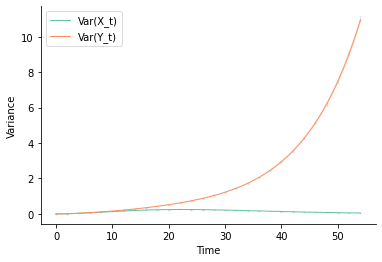

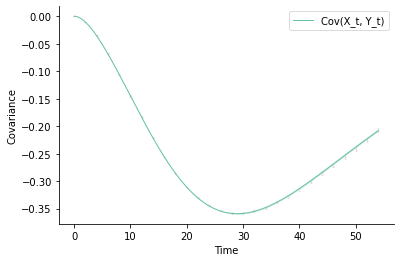

In [31]:
est = est_res_int[7]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)

est = est_res_int[17]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)

##### Estimation of external simulated data

In [34]:
print(data_int.data_mean - data_ext.data_mean)

[[[ 0.00000000e+00  1.28000000e-03  2.06000000e-03  2.66000000e-03
    5.40000000e-04  6.00000000e-05  2.64000000e-03  4.50000000e-03
    2.86000000e-03  3.68000000e-03  1.04000000e-03  2.16000000e-03
    1.16000000e-03 -8.80000000e-04 -1.20000000e-04  6.60000000e-04
    2.08000000e-03  2.36000000e-03  9.60000000e-04  1.20000000e-03
    6.40000000e-04  1.10000000e-03  5.20000000e-04  2.22000000e-03
    1.40000000e-03  6.20000000e-04 -1.40000000e-04 -3.40000000e-04]
  [ 0.00000000e+00 -1.30000000e-03 -2.06000000e-03 -2.88000000e-03
   -1.14000000e-03 -1.24000000e-03 -4.06000000e-03 -5.74000000e-03
   -5.70000000e-03 -6.98000000e-03 -4.62000000e-03 -6.84000000e-03
   -7.52000000e-03 -3.26000000e-03 -5.84000000e-03 -7.18000000e-03
   -8.88000000e-03 -9.98000000e-03 -1.21200000e-02 -1.23600000e-02
   -1.13800000e-02 -1.18800000e-02 -1.09800000e-02 -1.36400000e-02
   -1.93800000e-02 -1.61400000e-02 -1.26600000e-02 -1.27000000e-02]]

 [[ 0.00000000e+00 -1.21264221e-07 -3.17899896e-05  6.5983

In [35]:
variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]*len(nets)
initial_values = [{'X_t': 1, 'Y_t': 0}]*len(nets)
theta_bounds = [{'d4': (0.0, 0.15/2), 'd2': (0.0, 0.15/2), 'l': (0.0, 0.15)}]*len(nets)
        
est_res_ext = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_ext, parallel=True)

In [36]:
net_names = [est.net.net_name for est in est_res_ext]
model_probs = me.selection.compute_model_probabilities(est_res_ext)
print(net_names.index('net_4_2_3')) # true model
print(net_names.index('net_2_4_3')) # symmetric true model

17
7


In [41]:
print(net_names[7], model_probs[7])
print(net_names[17], model_probs[17])

net_2_4_3 0.4268741953575168
net_4_2_3 0.5731258046424296


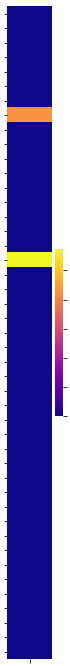

In [37]:
df = pd.DataFrame(model_probs * 100.0, index=net_names)
plt.figure(figsize=(1, 12)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.show()
# first run: 
# net_2_4_3 51.2%
# net_4_2_3 48.8%
# second run (new simulation data): 
# net_2_4_3 69.0%
# net_4_2_3 31.0%

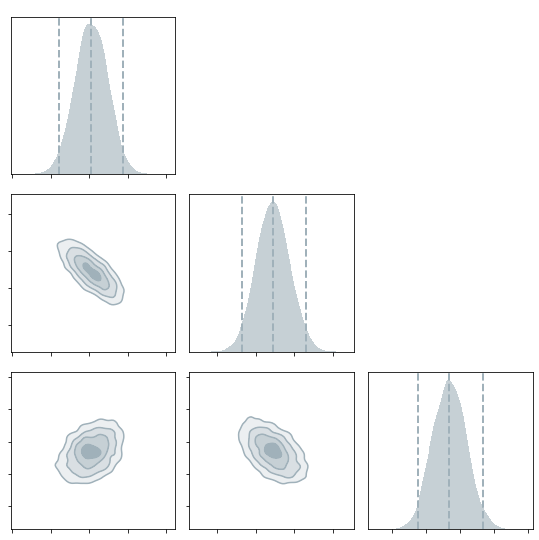

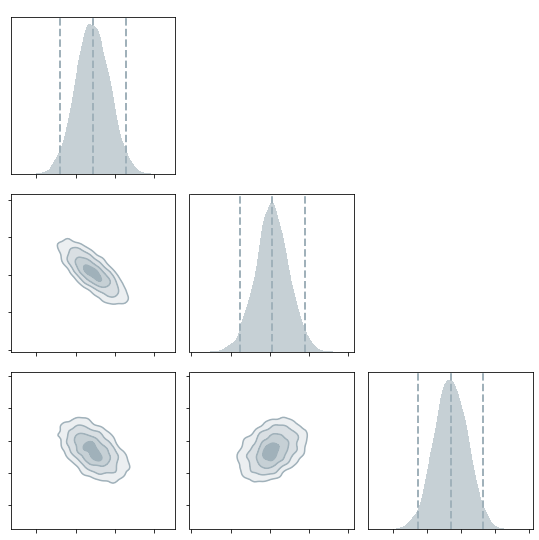

In [39]:
est = est_res_int[7]
me.plots.est_corner_kernel_plot(est)

est = est_res_int[17]
me.plots.est_corner_kernel_plot(est)
# first run estimated rates:
# net_4_2_3: d2=0.076, d4=0.063, l=0.060
# second run estimated rates (new simulation data):
# net_4_2_3: d2=0.080, d4=0.060, l=0.060

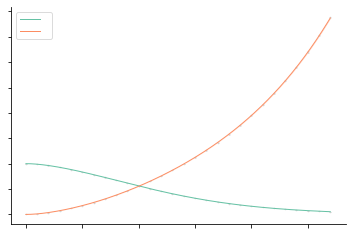

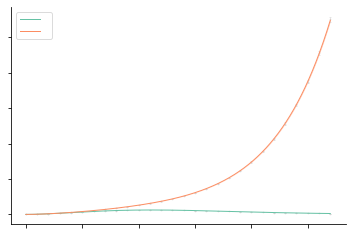

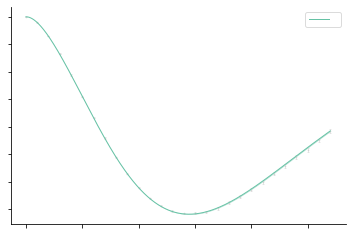

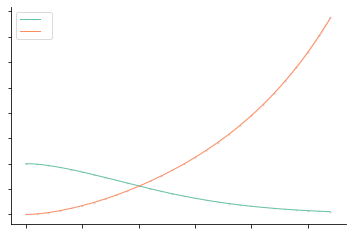

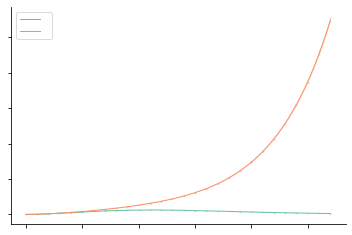

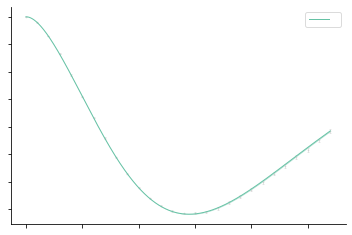

In [40]:
est = est_res_int[7]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)

est = est_res_int[17]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)